In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [3]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

21503


In [4]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

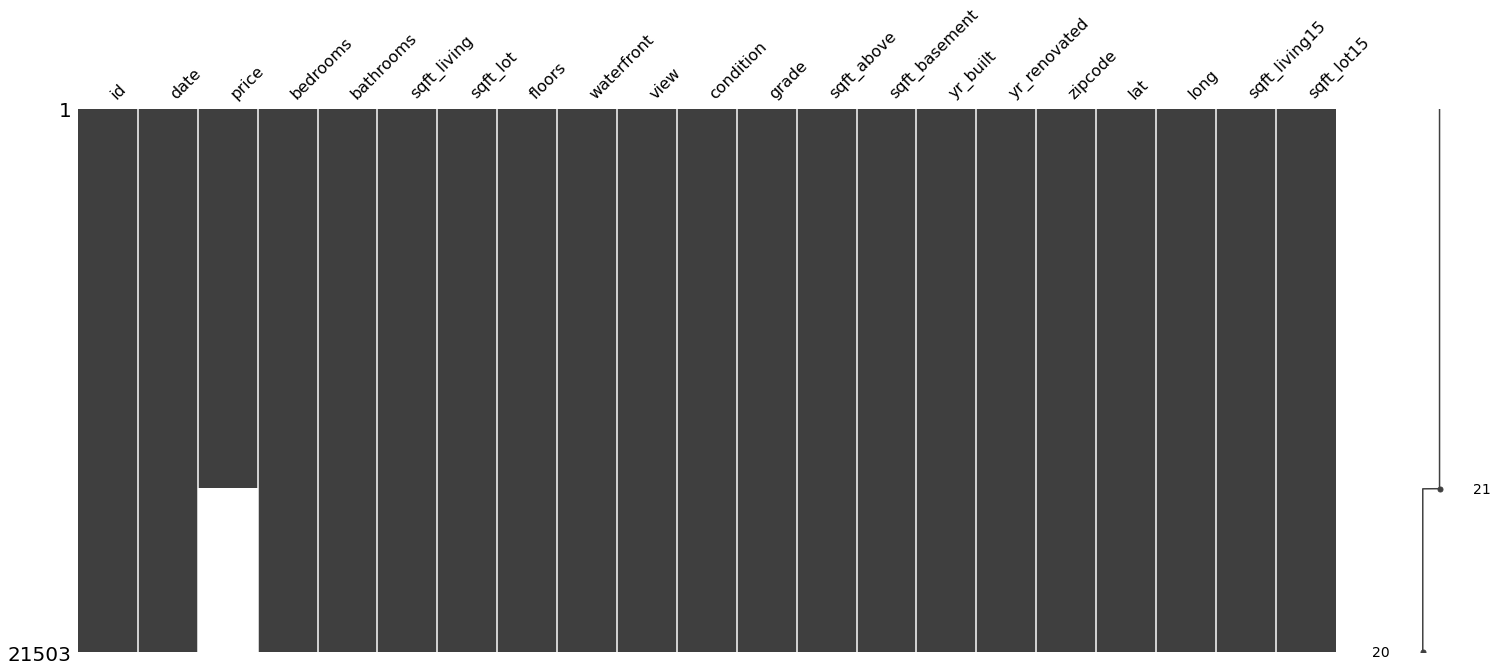

In [5]:
msno.matrix(data)

In [6]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [7]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


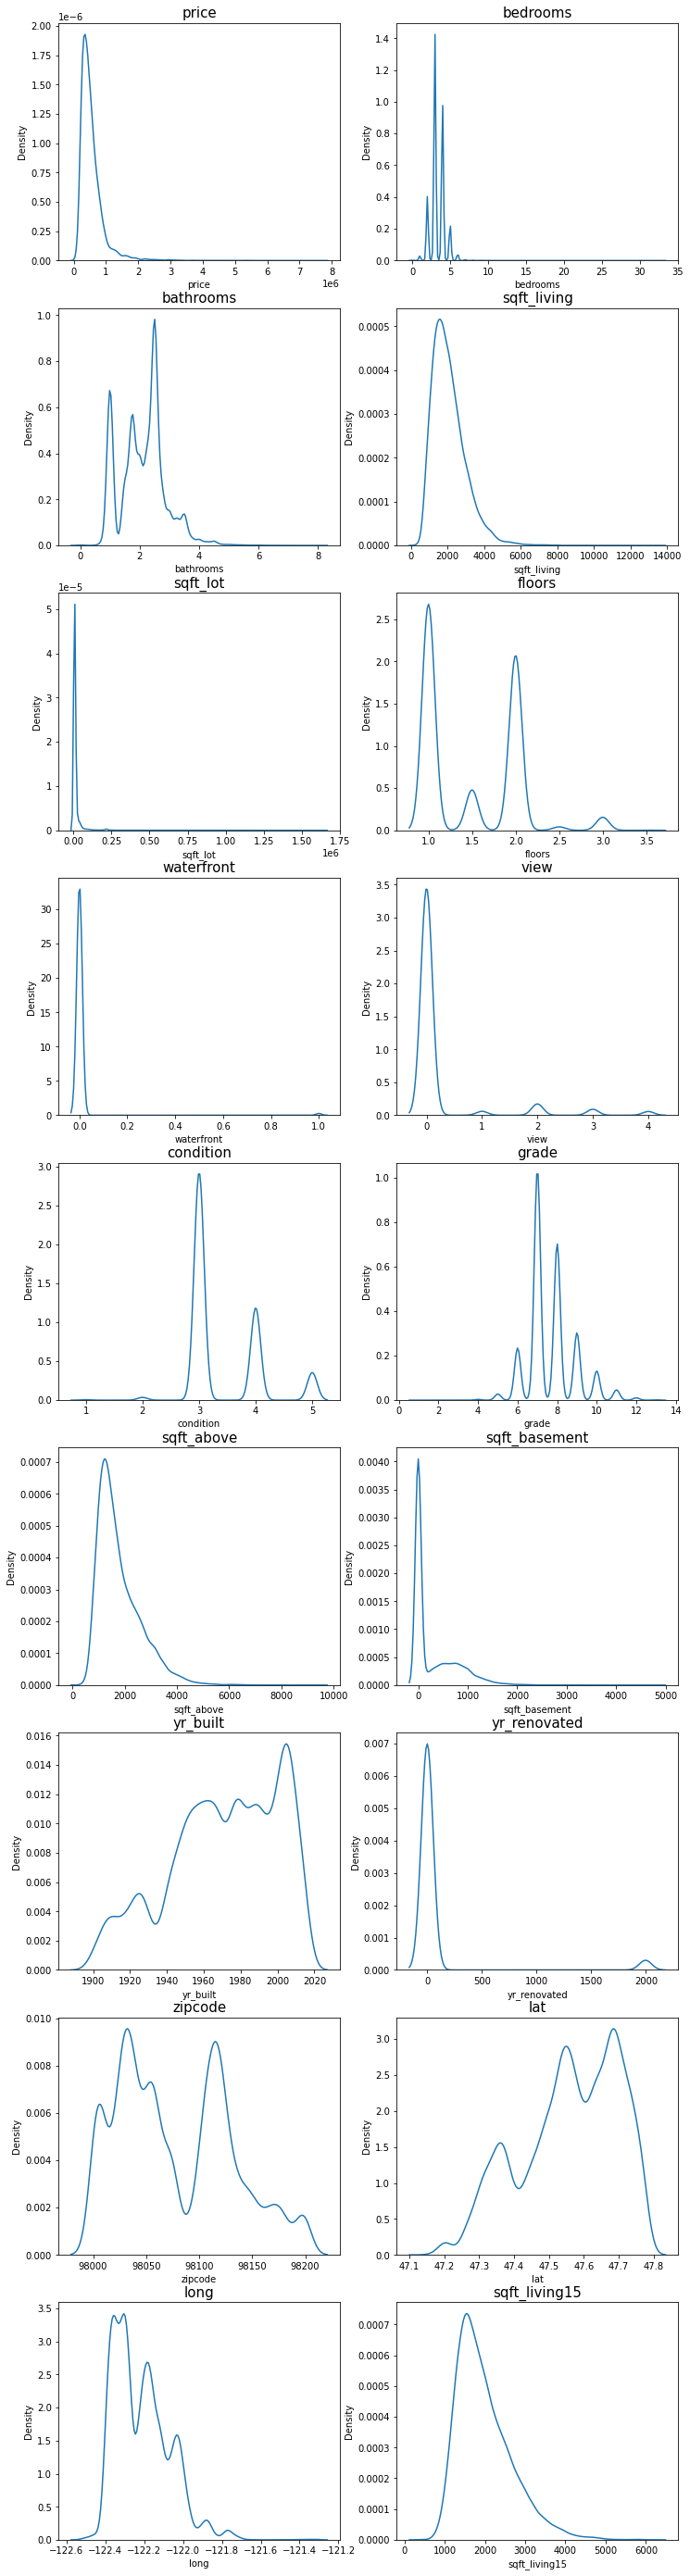

In [8]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [9]:
skew_columns = ['bedrooms', 'bathrooms', 'waterfront','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

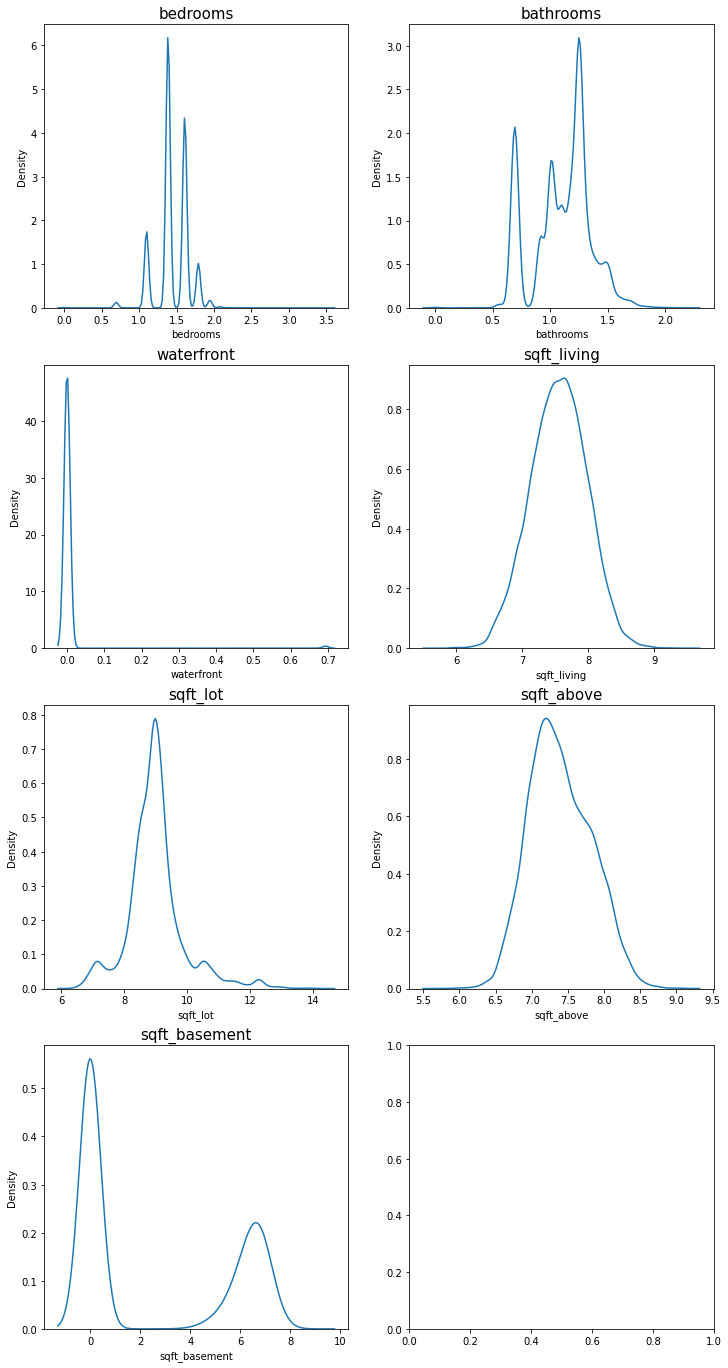

In [10]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(5):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [11]:
del data['zipcode']

In [12]:
data['view'].value_counts()

0    19385
2      962
3      507
1      332
4      317
Name: view, dtype: int64

In [13]:
data['condition'].value_counts()

3    13961
4     5657
5     1689
2      167
1       29
Name: condition, dtype: int64

In [14]:
data['grade'].value_counts()

7     8929
8     6050
9     2609
6     2017
10    1131
11     396
5      236
12      89
4       29
13      13
3        3
1        1
Name: grade, dtype: int64

In [15]:
data['waterfront'].value_counts()

0.000000    21340
0.693147      163
Name: waterfront, dtype: int64

In [16]:
data['sqft_basement'].value_counts()

0.000000    13056
6.398595      220
6.552508      217
6.216606      212
6.685861      206
            ...  
7.855932        1
7.694848        1
6.030685        1
8.089789        1
5.517453        1
Name: sqft_basement, Length: 306, dtype: int64

In [17]:
data = pd.get_dummies(data, columns = ['view', 'condition', 'grade','waterfront'])
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,waterfront_0.0,waterfront_0.6931471805599453
0,20141013T000000,221900.0,1.386294,0.693147,7.074117,8.639588,1.0,7.074117,0.000000,1955,...,0,1,0,0,0,0,0,0,1,0
1,20150225T000000,180000.0,1.098612,0.693147,6.647688,9.210440,1.0,6.647688,0.000000,1933,...,1,0,0,0,0,0,0,0,1,0
2,20150218T000000,510000.0,1.386294,1.098612,7.427144,8.997271,1.0,7.427144,0.000000,1987,...,0,0,1,0,0,0,0,0,1,0
3,20140627T000000,257500.0,1.386294,1.178655,7.447751,8.827615,2.0,7.447751,0.000000,1995,...,0,1,0,0,0,0,0,0,1,0
4,20150115T000000,291850.0,1.386294,0.916291,6.966967,9.181118,1.0,6.966967,0.000000,1963,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,20140626T000000,NaN,1.386294,1.011601,7.313887,9.390075,1.0,7.313887,0.000000,2014,...,1,0,0,0,0,0,0,0,1,0
6464,20150126T000000,NaN,1.386294,1.098612,7.307202,7.027315,3.0,7.307202,0.000000,2014,...,0,0,1,0,0,0,0,0,1,0
6465,20150219T000000,NaN,1.386294,1.252763,7.178545,7.166266,2.0,7.074117,4.875197,2008,...,0,0,1,0,0,0,0,0,1,0
6466,20140623T000000,NaN,1.098612,0.559616,6.928538,7.208600,2.0,6.928538,0.000000,2009,...,0,1,0,0,0,0,0,0,1,0


In [18]:
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,waterfront_0.0,waterfront_0.6931471805599453
0,201410,221900.0,1.386294,0.693147,7.074117,8.639588,1.0,7.074117,0.000000,1955,...,0,1,0,0,0,0,0,0,1,0
1,201502,180000.0,1.098612,0.693147,6.647688,9.210440,1.0,6.647688,0.000000,1933,...,1,0,0,0,0,0,0,0,1,0
2,201502,510000.0,1.386294,1.098612,7.427144,8.997271,1.0,7.427144,0.000000,1987,...,0,0,1,0,0,0,0,0,1,0
3,201406,257500.0,1.386294,1.178655,7.447751,8.827615,2.0,7.447751,0.000000,1995,...,0,1,0,0,0,0,0,0,1,0
4,201501,291850.0,1.386294,0.916291,6.966967,9.181118,1.0,6.966967,0.000000,1963,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,NaN,1.386294,1.011601,7.313887,9.390075,1.0,7.313887,0.000000,2014,...,1,0,0,0,0,0,0,0,1,0
6464,201501,NaN,1.386294,1.098612,7.307202,7.027315,3.0,7.307202,0.000000,2014,...,0,0,1,0,0,0,0,0,1,0
6465,201502,NaN,1.386294,1.252763,7.178545,7.166266,2.0,7.074117,4.875197,2008,...,0,0,1,0,0,0,0,0,1,0
6466,201406,NaN,1.098612,0.559616,6.928538,7.208600,2.0,6.928538,0.000000,2009,...,0,1,0,0,0,0,0,0,1,0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           21503 non-null  int64  
 1   price                          15035 non-null  float64
 2   bedrooms                       21503 non-null  float64
 3   bathrooms                      21503 non-null  float64
 4   sqft_living                    21503 non-null  float64
 5   sqft_lot                       21503 non-null  float64
 6   floors                         21503 non-null  float64
 7   sqft_above                     21503 non-null  float64
 8   sqft_basement                  21503 non-null  float64
 9   yr_built                       21503 non-null  int64  
 10  yr_renovated                   21503 non-null  int64  
 11  lat                            21503 non-null  float64
 12  long                           21503 non-null  

In [20]:
data.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,waterfront_0.0,waterfront_0.6931471805599453
count,21503.000000,1.503500e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,...,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,201438.639539,5.406827e+05,1.452955,1.105551,7.551722,8.990284,1.495140,7.396348,2.530451,1971.055016,...,0.093801,0.415244,0.281356,0.121332,0.052597,0.018416,0.004139,0.000605,0.992420,0.007580
std,44.281419,3.715247e+05,0.213407,0.251864,0.424418,0.902629,0.540183,0.427322,3.170984,29.372398,...,0.291558,0.492776,0.449671,0.326520,0.223233,0.134453,0.064203,0.024581,0.086737,0.086737
min,201405.000000,7.800000e+04,0.000000,0.000000,5.673323,6.255750,1.000000,5.673323,0.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201407.000000,3.220000e+05,1.386294,1.011601,7.266129,8.525360,1.000000,7.090910,0.000000,1951.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,201410.000000,4.500000e+05,1.386294,1.178655,7.557473,8.938138,1.500000,7.353082,0.000000,1975.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,201502.000000,6.450000e+05,1.609438,1.252763,7.844241,9.276783,2.000000,7.701200,6.329721,1997.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,201505.000000,7.700000e+06,3.526361,2.197225,9.513477,14.317110,3.500000,9.149634,8.480737,2015.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
train = data[:train_len]
test = data[train_len:]
del test['price']
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 39)
sub data dim : (6468, 38)


In [22]:
target = train['price']
del train['price']

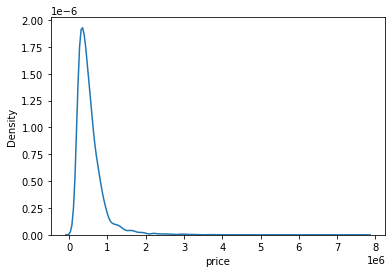

In [23]:
sns.kdeplot(data=target)
plt.show()

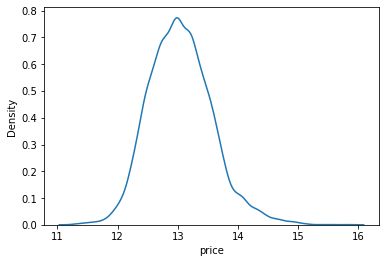

In [24]:
target = np.log1p(target)
sns.kdeplot(target)
plt.show()

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           15035 non-null  int64  
 1   bedrooms                       15035 non-null  float64
 2   bathrooms                      15035 non-null  float64
 3   sqft_living                    15035 non-null  float64
 4   sqft_lot                       15035 non-null  float64
 5   floors                         15035 non-null  float64
 6   sqft_above                     15035 non-null  float64
 7   sqft_basement                  15035 non-null  float64
 8   yr_built                       15035 non-null  int64  
 9   yr_renovated                   15035 non-null  int64  
 10  lat                            15035 non-null  float64
 11  long                           15035 non-null  float64
 12  sqft_living15                  15035 non-null 

In [26]:
def rmse(test_target, pred):
    return np.sqrt(mean_squared_error(np.expm1(test_target), np.expm1(pred)))

In [206]:
def my_GridSearch(model, train_input, train_target, param = param, n_jobs = -1):
    gs = GridSearchCV(model, param = param, scoring='neg_mean_squared_error', n_jobs = n_jobs)

    gs.fit(train, y)
    params = gs.cv_results_['params']
    score = gs.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['RMSLE'] = np.sqrt(-1 * score)
    results.sort_values('RMSLE', inplace = True)
    return results

xgb = XGBRegressor(tree_method = 'hist', random_state = 42)
my_GridSearch(xgb, train, target, param, n_jobs = -1)

TypeError: __init__() got an unexpected keyword argument 'param'

In [235]:
xgb = XGBRegressor(tree_method = 'hist', random_state = 42)
gs = GridSearchCV(xgb, param, scoring='neg_mean_squared_error', n_jobs = -1)

In [236]:
gs.fit(train, target)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method='hist',
                                

In [237]:
gs.best_params_

{'eta': 0.01, 'max_depth': 6}

In [238]:
gs.cv_results_['mean_test_score']

array([-9.01655419e+10, -8.77123875e+10])

In [239]:
xgbr = gs.best_estimator_
xgbr.score(train, target)

0.42689254798654186

In [240]:
prediction = xgbr.predict(test)
prediction

array([315771.1 , 266271.66, 970051.6 , ..., 275456.1 , 266620.3 ,
       247204.25], dtype=float32)

In [241]:
prediction = np.expm1(prediction)
prediction

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

[17:32:15] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:32:23] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:32:26] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issu

In [166]:
model = ['XGBRegressor',
         'LGBMRegressor',
         'RandomForestRegressor',
         'ExtraTreesRegressor',
         'GradientBoostingRegressor',
         'HistGradientBoostingRegressor']

In [230]:
param = {'max_depth' : range(5, 7, 1),
         'eta' : np.arange(0.01, 1)
        }

In [163]:
[0.1 / 10**i for i in np.arange(1)]

[0.1]

In [229]:
np.arange(0.01, 1)

array([0.01, 1.01])